In [80]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams as rc
rc['figure.figsize'] = (20,10)

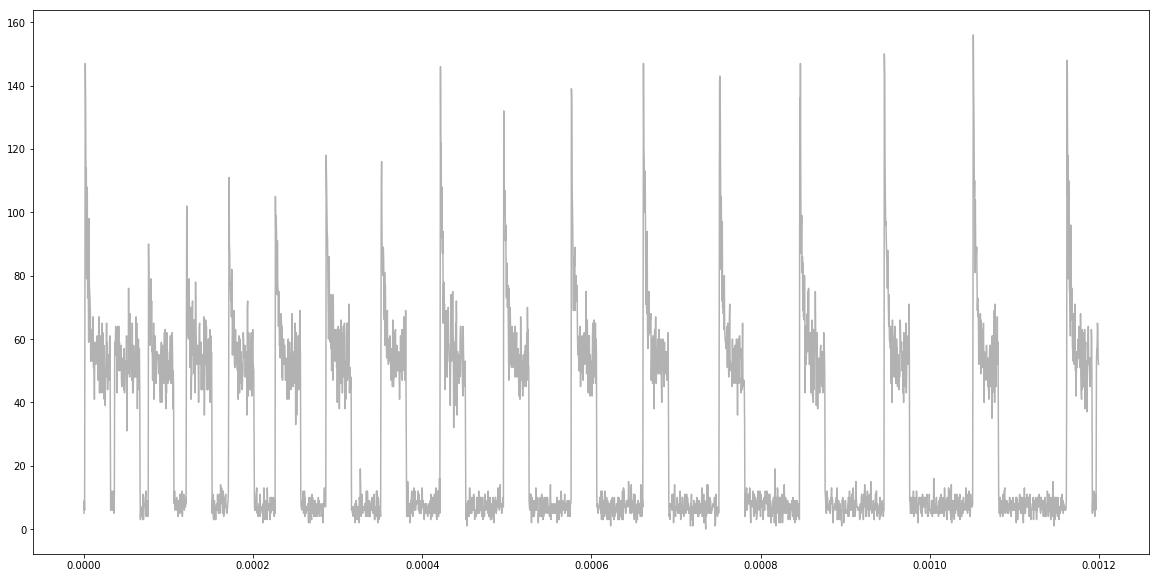

In [124]:
dir_ = "Data\Spin Lifetime"
fname = "Histogram-2_2022-04-19_19-35-18.txt"
data = np.genfromtxt(os.path.join(dir_,fname))

ts, cts = data[:,0]*1e-12, data[:,1]
mask = np.logical_not(np.isnan(cts))
ts = ts[mask]
cts = cts[mask]
t_step = np.mean(np.diff(ts))
plt.plot(ts, cts, '-k', alpha=0.3)

c:\program files (x86)\python36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


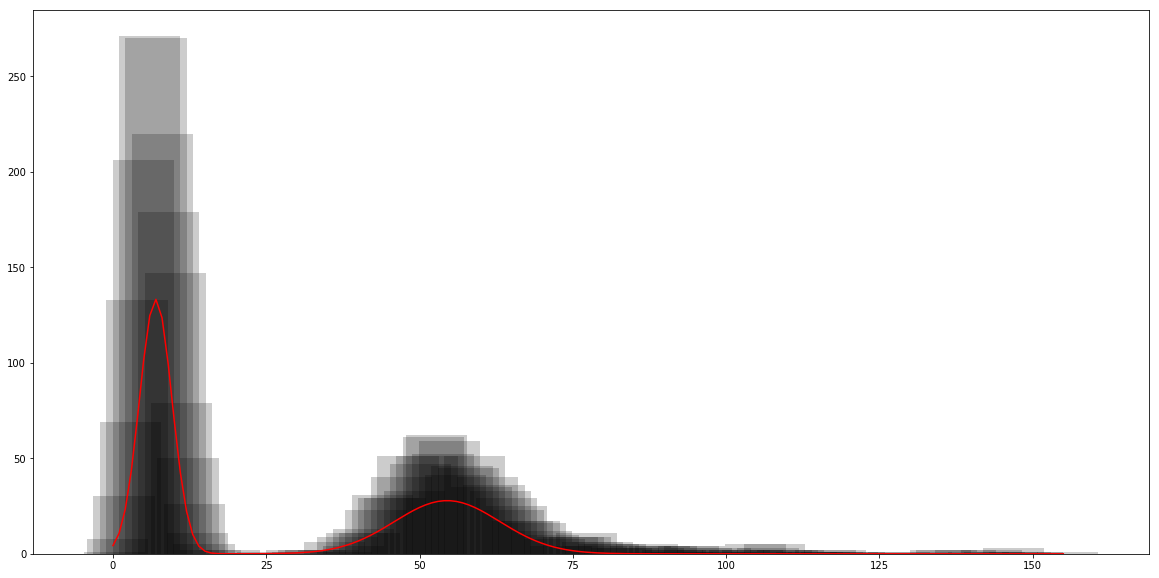

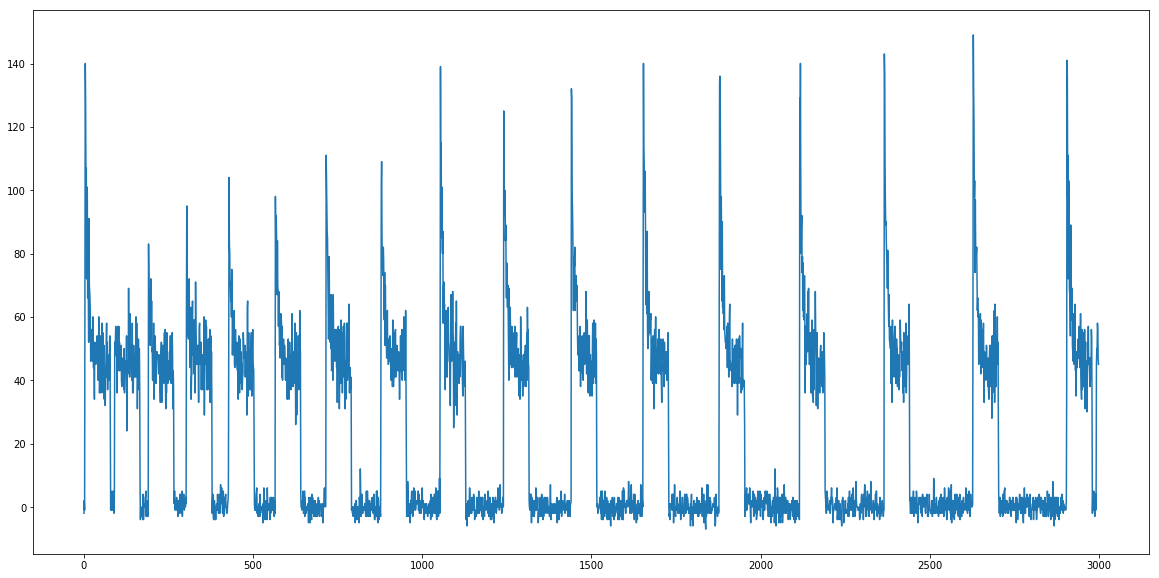

In [125]:
from scipy.stats import poisson
from scipy.optimize import curve_fit

def lorentzian(x, Gamma, mu):
    return 1/np.pi * (Gamma/2)**2/((x-mu)**2 + (Gamma/2)**2)

def lorentzian_fit(x, a, Gamma, mu):
    return a*lorentzian(x, Gamma, mu)


def gaussian(x, sigma, mu):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

def gaussian_fit(x, a, sigma, mu):
    return a*gaussian(x, sigma, mu)

def double_gaussian_fit(x, a1, sigma1, mu1, a2, sigma2, mu2):
    return a1*gaussian(x, sigma1, mu1) + a2*gaussian(x, sigma2, mu2)

bin_count = int(len(cts)/10)
hist, bins = np.histogram(cts, bins=bin_count)
bins_ctr = (bins[:-1] + bins[1:])/2

plt.bar(bins_ctr, hist, width=10, color='k', alpha=0.2)

p0 = (1, 1, 0.1*np.max(bins_ctr), 1, 10, 0.9*np.max(bins_ctr))
bounds = ([],[])
popt, pcov = curve_fit(double_gaussian_fit, 
                       bins_ctr, hist, 
                       p0=p0)
popt_std = np.diag(np.sqrt(pcov))
bins_fit = np.arange(0,np.max(bins_ctr),1)
plt.plot(bins_fit, double_gaussian_fit(bins_fit, *popt), '-r')
plt.show()

cts_bg = min(popt[2], popt[5])
cts_ss = max(popt[2], popt[5])
plt.plot(cts-cts_bg)
plt.show()

[  12   12   13   13   12   12   13   13   12   12   13   13   12   12
   15 -189] 48.80573736764972 23.625
Dropping 1 edges


Text(0.5,1,'Positive edges')

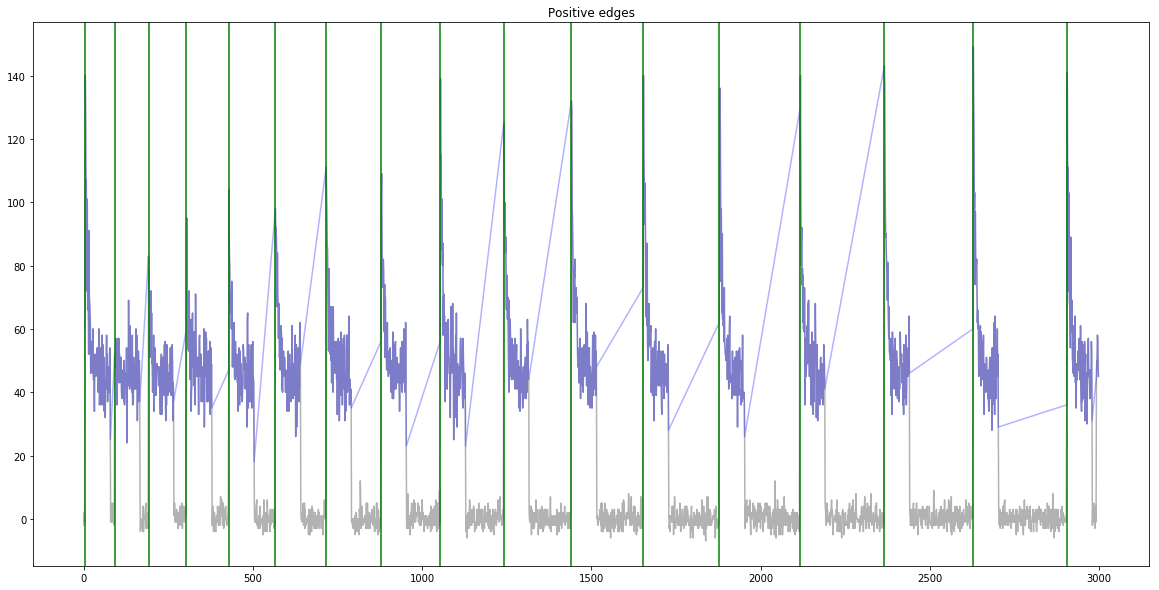

In [126]:
cts_shifted = np.copy(cts)
cts_shifted = cts_shifted[np.argwhere(cts_shifted<cts_bg)[0][0]:]
cts_shifted = cts_shifted - cts_bg
thr = (cts_ss-cts_bg)/3

# Take all cts which are above the given threshold, since those are the relevant ones of the pulse sequence to analyze
cts_thr_idxs = np.argwhere(cts_shifted>thr).flatten()

plt.plot(cts_shifted, '-k', alpha=.3)
plt.plot(cts_thr_idxs, cts_shifted[cts_thr_idxs], '-b', alpha=.3)

# In order to find all pulse edges, analyze discontinouities from the cts above threshold, i.e. jump in indexes (diff>1)
# np.diff returns array where the difference is calculated the array a as such d[i] = a[i+1] - a_[i].
# As a result, start with indexes of cts abovethreshold from 1 - N.
cts_posedge_idxs = np.copy(cts_thr_idxs[1:])
cts_posedge_idxs = cts_posedge_idxs[np.diff(cts_thr_idxs)>1]
# Insert first pos edge which is missed by the the diff operation 
cts_posedge_idxs = np.insert(cts_posedge_idxs,0,cts_thr_idxs[0])
# for pos_edge in cts_posedge_idxs:    
#     plt.axvline(pos_edge, color='r', alpha=.5)
    
# Pulse widths is roughly equal the difference in edge_idxs which should be roughly a constant
pulse_width = np.diff(cts_posedge_idxs)
pulse_incr = np.diff(pulse_width)

# Check if there are pulse increments which are outliers, i.e. theirs absolutes are larger than the mean
mean_pulse_incr = np.mean(np.abs(pulse_incr))
# Discard the outliers which can only occure at the sequence boundaries
print(pulse_incr, np.std(pulse_incr), mean_pulse_incr)
if np.std(pulse_incr)>=mean_pulse_incr:
    posedge_drops = np.argwhere(np.abs(pulse_incr)>mean_pulse_incr).flatten()
    posedge_drops = posedge_drops/np.amax(posedge_drops) * (len(cts_posedge_idxs)-1) if len(posedge_drops)>0 else posedge_drops

    cts_posedge_idxs = np.delete(cts_posedge_idxs, posedge_drops.astype('int'))
    print(f"Dropping {len(posedge_drops)} edges")
    
for pos_edge in cts_posedge_idxs:    
    plt.axvline(pos_edge, color='g')
   
plt.title("Positive edges")

Text(0.5,1,'Negative edges')

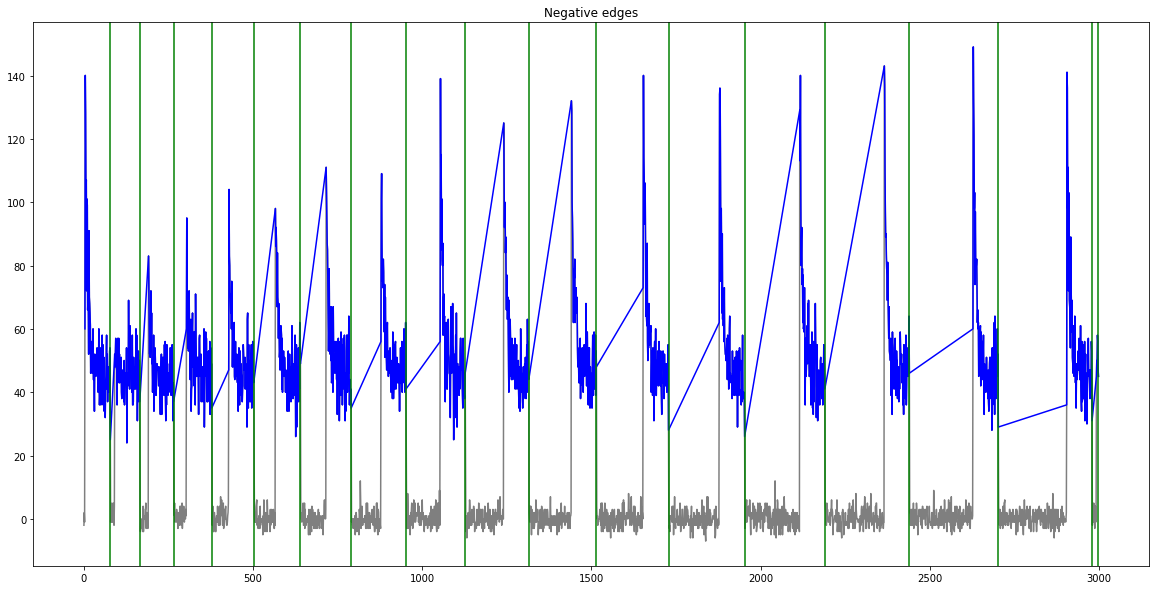

In [127]:
cts_shifted = np.copy(cts)
cts_shifted = cts_shifted[np.argwhere(cts_shifted<cts_bg)[0][0]:]
thr = (cts_ss-cts_bg)/2
cts_shifted = cts_shifted - cts_bg

# Take all cts which are above the given threshold, since those are the relevant ones of the pulse sequence to analyze
cts_thr_idxs = np.argwhere(cts_shifted>thr).flatten()

plt.plot(cts_shifted, '-k', alpha=0.5)
plt.plot(cts_thr_idxs, cts_shifted[cts_thr_idxs], '-b', alpha=1)

# In order to find all pulse edges, analyze discontinouities from the cts above threshold, i.e. jump in indexes (diff>1)
# np.diff returns array where the difference is calculated the array a as such d[i] = a[i+1] - a_[i].
# As a result, start with indexes of cts abovethreshold from 1 - N.
cts_negedge_idxs = np.copy(cts_thr_idxs[:-1])
cts_negedge_idxs = cts_negedge_idxs[np.diff(cts_thr_idxs)>1]
    
# Pulse widths is roughly equal the difference in edge_idxs which should be roughly a constant
pulse_width = np.diff(cts_negedge_idxs)
pulse_incr = np.diff(pulse_width)

# Check if there are pulse increments which are outliers, i.e. theirs absolutes are larger than the mean
mean_pulse_incr = np.mean(np.abs(pulse_incr))
# Discard the outliers
if np.std(pulse_incr)>=mean_pulse_incr:
    negedge_drops = np.argwhere(np.abs(pulse_incr)>mean_pulse_incr).flatten()
    cts_negedge_idxs = np.delete(cts_negedge_idxs, negedge_drops)
    print("Dropping egdes")

# Append the last negative edge
cts_negedge_idxs = np.append(cts_negedge_idxs, cts_thr_idxs[-1])
for neg_edge in cts_negedge_idxs:    
    plt.axvline(neg_edge, color='g')

plt.title("Negative edges")

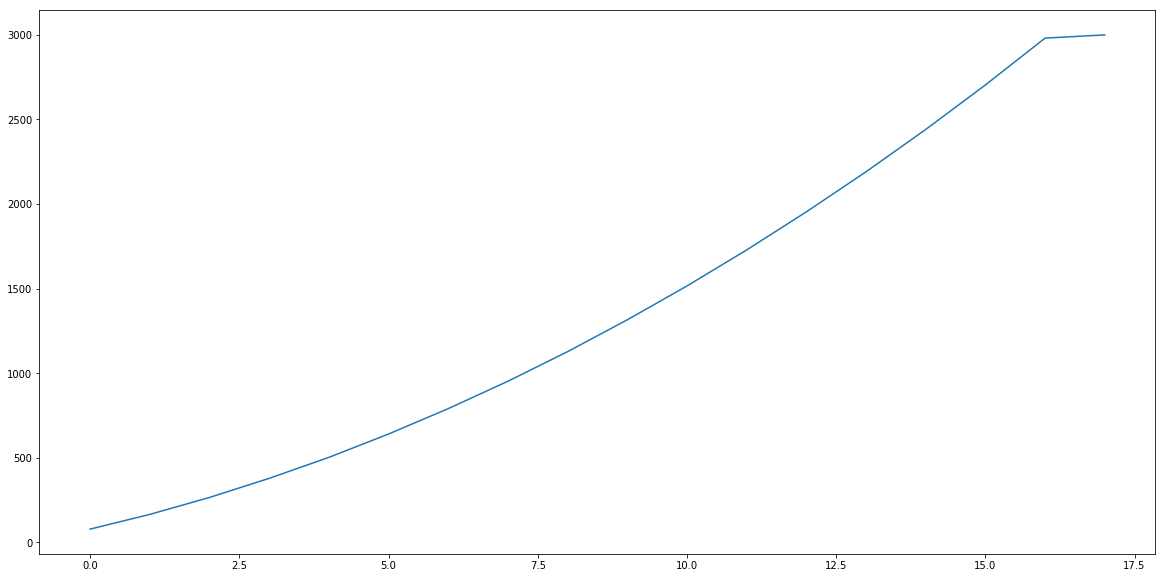

In [128]:
plt.plot(cts_negedge_idxs)
cts_negedge_idxs = cts_negedge_idxs[:-1]

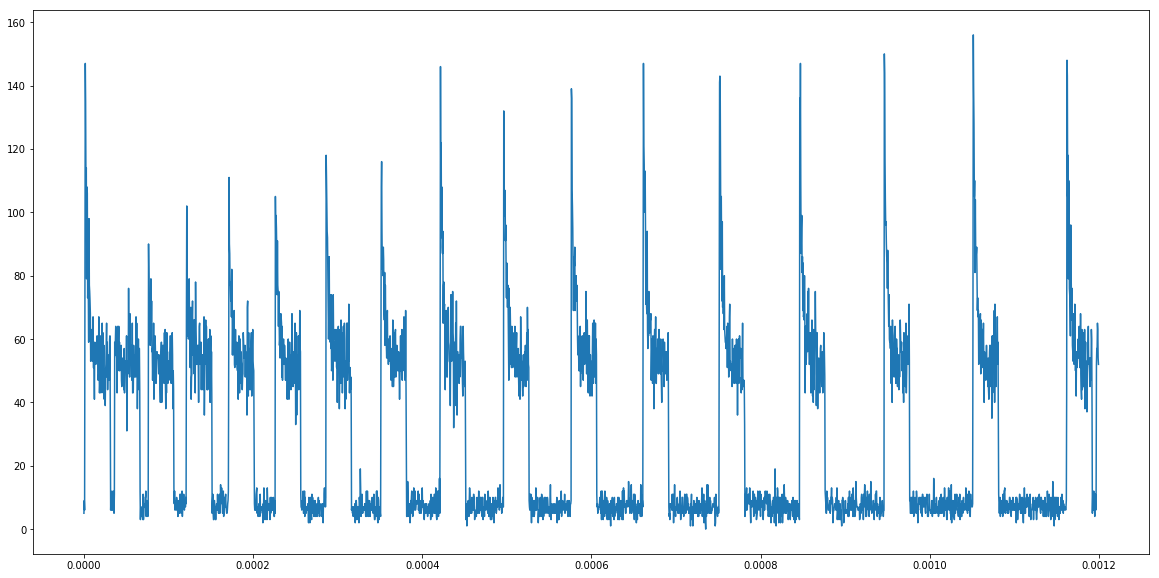

In [132]:
plt.plot(ts, cts)

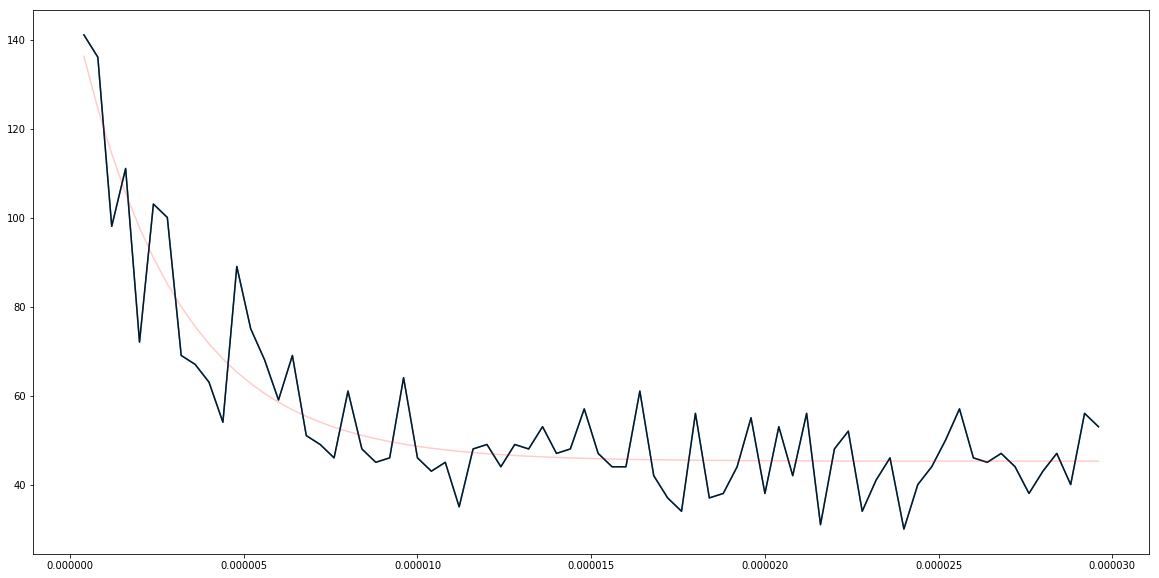

In [153]:
plt.plot(t_pulse_fit, pulse[np.argmax(pulse): len(pulse)])
p0 = (np.max(pulse)-pulse[-1], len(pulse)/2*t_step, pulse[-1])
popt_pulse_decay, pcov_pulse_decay = curve_fit(decay, t_pulse_fit, pulse[np.argmax(pulse): len(pulse)], p0=p0)
plt.plot(t_pulse_fit, pulse[np.argmax(pulse):], '-k', alpha=0.8)
plt.plot(t_pulse_fit, decay(t_pulse_fit, *popt_pulse_decay), '-r', alpha=0.2)   

Found 17 pulses
Mean fit error of pulse decay in %:  0.06992052941029203
Mean fit error of pulse decay in %:  5.851476458393567
Mean fit error of pulse decay in %:  0.1461029872211668
Mean fit error of pulse decay in %:  0.19400770613152085
Mean fit error of pulse decay in %:  0.1025252857662222
Mean fit error of pulse decay in %:  0.08191335268890541
Mean fit error of pulse decay in %:  0.0884449733547676
Mean fit error of pulse decay in %:  0.09238966850828591
Mean fit error of pulse decay in %:  0.08420258554940653
Mean fit error of pulse decay in %:  0.06138084942685971
Mean fit error of pulse decay in %:  0.07106139323385907
Mean fit error of pulse decay in %:  0.06266082927833348
Mean fit error of pulse decay in %:  0.06914187317359202
Mean fit error of pulse decay in %:  0.09837318321616034
Mean fit error of pulse decay in %:  0.05244995788434494
Mean fit error of pulse decay in %:  0.05916125969453693
Mean fit error of pulse decay in %:  0.07243902721359462
[ 9.93544454e-01 -1.

c:\program files (x86)\python36\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in sqrt
c:\program files (x86)\python36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


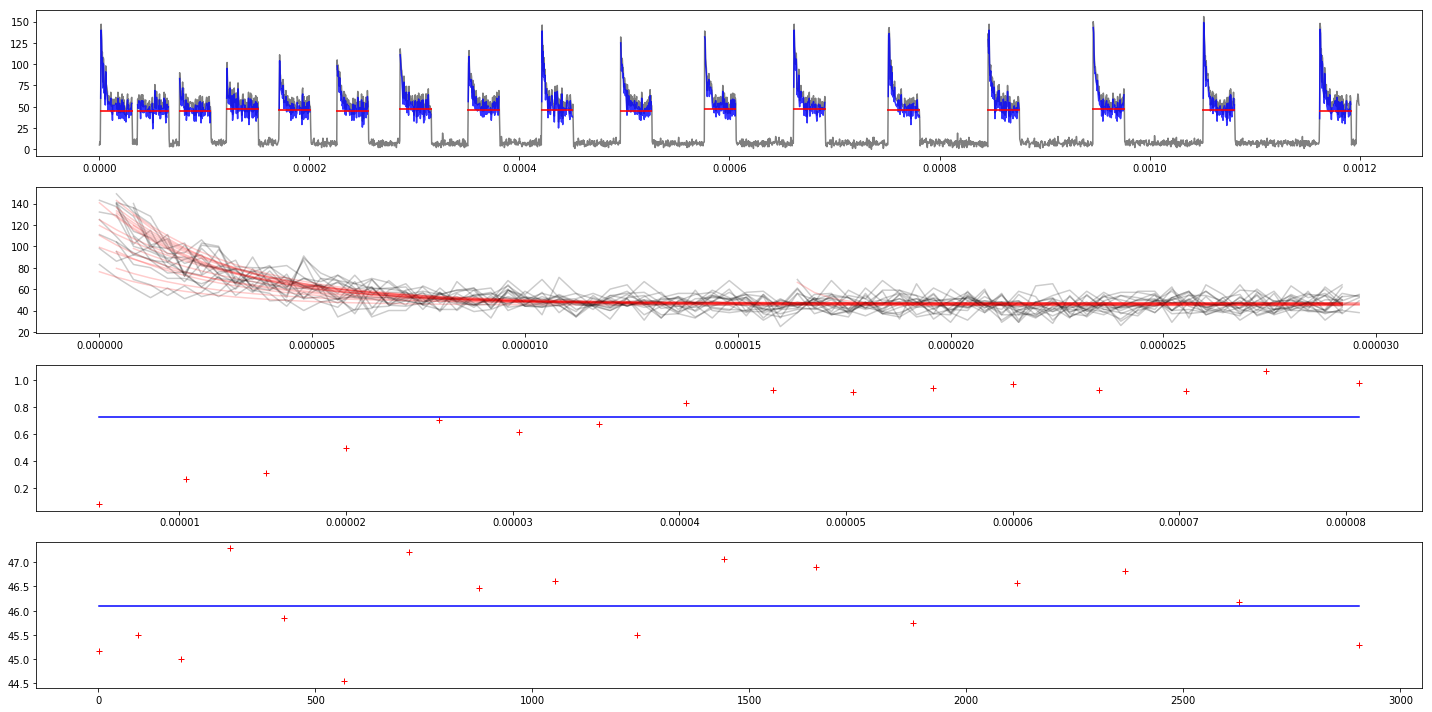

In [156]:
print(f"Found {len(cts_posedge_idxs)} pulses")

fig, axs = plt.subplots(4,1, figsize=(20,10))
time_res = 1e9

decay = lambda x, a, tau, c: a*np.exp(-x/tau)+c
peak_heights = []
peak_heights_err = []

ss_decay = lambda x, a, tau, c: a*np.exp(-x/tau)+c
ss_heights = []
axs[0].plot(ts, cts, '-k', alpha=0.5)

for i, (posedge, negedge) in enumerate(zip(cts_posedge_idxs, cts_negedge_idxs)):
    
    # Plot cut out pulses for the whole sequence
    pulse_idxs = np.arange(posedge,negedge)
    t_pulse = ts[pulse_idxs]
    pulse = cts_shifted[pulse_idxs]
    axs[0].plot(t_pulse, pulse, '-b', alpha=0.8)    
    
    # Try to estimate the decay of detection probability within one photon sequence due to missing start-multi-stop measurement    
    hist, bins = np.histogram(pulse[int(len(pulse)/2):], bins=int(len(pulse)/10))
    bins_ctr = (bins[:-1] + bins[1:])/2    
    p0 = (np.amax(hist), bins_ctr[np.argmax(hist)], np.amax(hist)/10)
    popt_ss, pcov_ss = curve_fit(gaussian_fit, bins_ctr, hist, p0=p0)            
    
    # Fit every pulse with an exponential decay starting at the pulse maximum
    t_pulse_fit = np.arange(np.argmax(pulse), len(pulse))*t_step
#     p0 = (np.amax(pulse), len(t_pulse_fit)/10, popt_ss[2])    
#     popt_pulse_decay, pcov_pulse_decay = curve_fit(decay, t_pulse_fit, pulse[np.argmax(pulse): len(pulse)], p0=p0)    
    p0 = (np.max(pulse)-pulse[-1], len(pulse)/2*t_step, pulse[-1])
    popt_pulse_decay, pcov_pulse_decay = curve_fit(decay, t_pulse_fit, pulse[np.argmax(pulse): len(pulse)], p0=p0)

    axs[1].plot(t_pulse_fit, pulse[np.argmax(pulse):], '-k', alpha=0.2)
    axs[1].plot(t_pulse_fit, decay(t_pulse_fit, *popt_pulse_decay), '-r', alpha=0.2)    
    print("Mean fit error of pulse decay in %: ", np.mean(np.abs(np.sqrt(np.diag(pcov_pulse_decay))/popt_pulse_decay)))
    
    # Peak heights are calculated by summing all counts in one pulse and subtracting the stationary ones. Additionally, 
    # the resulting value is normalized to the stationary count rate, since it drops exponentially off due to the measurement
    # instrument    
    ss_height = popt_pulse_decay[2]
    ss_heights.append([posedge, ss_height])
    axs[0].plot(t_pulse, ss_height*np.ones_like(t_pulse), '-r', alpha=0.8, lw=2)        
    
#     peak_heights.append(popt_pulse_decay[1])
    peak_heights.append((np.sum(pulse)-ss_height*len(t_pulse)))
        
    # Errors are calculated with Gaussian Error Propagation 
    peak_heights_err.append(pcov_pulse_decay[2,2]*len(t_pulse))
        
axs[2].plot(peak_incrs, peak_heights[1:]/peak_heights[0], color='r', marker='+', linestyle='')
    
recovery = lambda x, a, T1, c: (1-a*np.exp(-x/T1))*c
p0 = (0.1, 40000, np.amax(peak_heights))
peak_incrs = (cts_posedge_idxs[1:]-cts_negedge_idxs[:-1])*t_step
popt_recovery, pcov_recovery = curve_fit(f=recovery, 
                                         xdata=peak_incrs, ydata=peak_heights[1:]/peak_heights[0])

axs[2].plot(peak_incrs, recovery(peak_incrs, *popt_recovery), '-b')
print(popt_recovery)
print(f"Recovery time {round(popt_recovery[1],2)}ns")
print(f"Error {np.diag(np.sqrt(pcov_recovery))[1]}")

ss_heights = np.array(ss_heights)
p0 = (10, ss_heights[0,0], ss_heights[0,-1])
popt, pcov = curve_fit(ss_decay, ss_heights[:,0], ss_heights[:,1], p0=p0)
axs[3].plot(ss_heights[:,0], ss_heights[:,1], '+r')
axs[3].plot(ss_heights[:,0], ss_decay(ss_heights[:,0], *popt), '-b')
plt.tight_layout()

In [162]:
1-pulse[-1]/(2*np.max(pulse))

0.8119857633054383

In [ ]:
peak_heights = []
for i in range(data_.shape[1]):    
    pulse = data_[:,i][np.argmax(data_[:,i]): data_.shape[0]-5]
    t_pulse = np.arange(np.argmax(data_[:,i]), data_.shape[0]-5, 1)
    
    rad_decay = lambda x, a, tau, c: a*np.exp(-x/tau) + c
    popt, pcov = curve_fit(rad_decay, t_pulse, pulse)
#     plt.plot(t_pulse, pulse, '-k', alpha=0.5)
#     plt.plot(t_pulse, rad_decay(t_pulse, *popt), '-r', alpha=0.5)
#     plt.show()
    peak_heights.append(np.sum(pulse) - popt[2]*len(t_pulse))
peak_heights = np.array(peak_heights)
peak_heights = peak_heights/np.amax(peak_heights)

In [86]:
incr = 35
incrs = np.arange(incr,len(peak_heights)*incr,incr)
t1_rec = lambda x, a, tau: 1-a*np.exp(-x/tau)
p0 = (1, 100)
popt, pcov = curve_fit(t1_rec, incrs, peak_heights[1:], p0=p0)

In [25]:
plt.plot(incrs, peak_heights[1:], '+k', alpha=0.5)
plt.plot(incrs, t1_rec(incrs, *popt), '-r', alpha=0.5)
popt

NameError: name 'incrs' is not defined

In [65]:
incrs

array([ 35,  70, 105, 140, 175, 210, 245, 280, 315, 350])